Combining remote sensing data from Google Earth Engine (GEE) with the spatial data processing capabilities of GeoPandas opens up a new avenue for advanced geographic analyses. GEE provides access to a comprehensive archive of satellite imagery and geospatial datasets, while GeoPandas extends the popular pandas library to allow for efficient operations of vector data. By leveraging the strengths of both platforms, researchers can perform sophisticated spatial operations, from overlay analyses to spatial joins, enhancing the possibilities of geospatial analysis and depth of research questions. To illustrate the integration of GEE with GeoPandas, we will study the extend of major habitat fragmentation.


## Habitat fragmentation problem

The Flint Hills is a region is one of the last remaining tallgrass prairies in North America. This unique ecosystem is home to a rich biodiversity, including numerous grassland bird species, diverse plant life, and a variety of other wildlife. The Flint Hills have resisted the plow thanks to their rocky terrain, preserving an expanse of native grasslands that once covered much of the Great Plains. This area not only offers a glimpse into America's natural heritage but also serves as a critical refuge for species that thrive in the prairie habitat.

Habitat fragmentation is a process where large continuous habitats are divided into smaller, isolated sections. Habitat fragmentation is a significant ecological concern, particularly in regions like the Flint Hills. Roads, one of the primary drivers of such fragmentation, can disrupt the interconnected landscapes, limiting animal movement, altering animal behavior, and increasing vulnerability to external threats like invasive species and climate change. In the Flint Hills, the expansion of road networks could potentially threaten the integrity of this pristine habitat.

In this exercise we explore some of the fragmentation caused by primary and secondary roads.


In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd
import requests
import xarray as xr
import ee



In [ ]:
# Authenticate GEE
#ee.Authenticate()

# Initialize GEE
ee.Initialize()

In [3]:
# Define CRS
utm14 = 32614 # UTM 14 projected coordinates in meters (good for Kansas)
wgs84 = 4326 # WGS84 geographic coordinates


## Load boundary of Flint Hills ecological region

In [4]:
# Load eco regions
eco_regions = ee.FeatureCollection("RESOLVE/ECOREGIONS/2017")

# Use this line to inspect properties
#eco_regions.first().propertyNames().getInfo()


In [5]:
# Select flint hills region
# Find ecoregion ID using their website: https://ecoregions.appspot.com
region = eco_regions.filter(ee.Filter.inList('ECO_ID',[392]))
region_data = region.getInfo()


In [6]:
# Convert to GeoDataframe
gdf_region = gpd.GeoDataFrame.from_features(region_data['features'], crs=wgs84)
gdf_region['geometry'] = gdf_region['geometry'].simplify(0.001)
gdf_region.head()


,geometry,BIOME_NAME,BIOME_NUM,COLOR,COLOR_BIO,COLOR_NNH,ECO_BIOME_,ECO_ID,ECO_NAME,LICENSE,NNH,NNH_NAME,OBJECTID,REALM,SHAPE_AREA,SHAPE_LENG
0,"POLYGON ((-97.36772 38.37556, -97.36465 38.359...","Temperate Grasslands, Savannas & Shrublands",8,#A87001,#FEFF73,#EE1E23,NE08,392,Flint Hills tallgrass prairie,CC-BY 4.0,4,Nature Imperiled,271,Nearctic,2.873636,9.461116


## Load primary and secondary roads

In [7]:
# Load TIGER roads dataset
roads_dataset = ee.FeatureCollection('TIGER/2016/Roads').filterBounds(region)
selected_roads = roads_dataset.filter(ee.Filter.inList('mtfcc',['S1100','S1200']))
roads_data = selected_roads.getInfo()

# Use this line to see available properties
# https://www2.census.gov/geo/pdfs/reference/mtfccs2017.pdf
# roads_dataset.first().propertyNames().getInfo()


In [8]:
# Convert Geodataframe
gdf_roads = gpd.GeoDataFrame.from_features(roads_data['features'], crs=wgs84)
gdf_roads.head()

,geometry,fullname,linearid,mtfcc,rttyp
0,"LINESTRING (-96.64559 39.84213, -96.64558 39.8...",US Hwy 77,1103942688564,S1200,U
1,"LINESTRING (-96.66120 36.78194, -96.66182 36.7...",1st St,110788715400,S1200,M
2,"LINESTRING (-96.65110 36.94044, -96.65108 36.9...",Hwy 18,1103942486000,S1200,M
3,"LINESTRING (-96.65181 36.93269, -96.65178 36.9...",Broadway,110788721819,S1200,M
4,"LINESTRING (-96.65110 36.94044, -96.65108 36.9...",Broadway,1103942485999,S1200,M


In [ ]:
# Show map
fig, ax = plt.subplots(1,1, figsize=(3,6))
gdf_region.plot(ax=ax, facecolor='None')
gdf_roads.plot(ax=ax, color='tomato')

## Unify roads into single Multiline feature

In [22]:
unified_roads = gdf_roads.unary_union
gdf_unified_roads = gpd.GeoDataFrame(geometry=[unified_roads], crs=gdf_roads.crs)
gdf_unified_roads['geometry'] = gdf_unified_roads['geometry'].simplify(0.001)
gdf_unified_roads.head()


,geometry
0,"MULTILINESTRING ((-96.64559 39.84213, -96.6435..."


## Create buffer area around roads

This step is needed to be able to compute intersection and difference with the boundary map. We will assign a buffer of 1 km on each side of each road to create clearly distinct polygons. If you work in smaller areas, a smaller buffer would be better. In this dataset, a couple of kilometers represents a small magnitude compared to the extent of the region.

In [246]:
# Create buffer as a GeoSeries
buffer_distance = 1000  # Example buffer distance
buffered_unified_roads = gdf_unified_roads.to_crs(utm14).buffer(buffer_distance).to_crs(gdf_roads.crs)


In [247]:
# Create a new GeoDataFrame with the buffered unified roads geometry
gdf_buffered_unified_roads = gpd.GeoDataFrame(geometry=gpd.GeoSeries(buffered_unified_roads),
                                              crs=gdf_roads.crs)

gdf_buffered_unified_roads.head()


,geometry
0,"MULTIPOLYGON (((-97.36906 38.91970, -97.37023 ..."


## Obtain fragmented areas

The key operation in this step is to compute the difference between layers.

In [248]:
# Obtained fragmented areas
fragmented_regions = gpd.overlay(gdf_region, gdf_buffered_unified_roads, how='difference')
fragmented_regions.head()


,geometry,BIOME_NAME,BIOME_NUM,COLOR,COLOR_BIO,COLOR_NNH,ECO_BIOME_,ECO_ID,ECO_NAME,LICENSE,NNH,NNH_NAME,OBJECTID,REALM,SHAPE_AREA,SHAPE_LENG
0,"MULTIPOLYGON (((-95.99115 39.43608, -95.91121 ...","Temperate Grasslands, Savannas & Shrublands",8,#A87001,#FEFF73,#EE1E23,NE08,392,Flint Hills tallgrass prairie,CC-BY 4.0,4,Nature Imperiled,271,Nearctic,2.873636,9.461116


In [249]:
# Explode the multipolygon feature
gdf_patches = fragmented_regions.explode(index_parts=True).reset_index(drop=True)
gdf_patches.head()


,BIOME_NAME,BIOME_NUM,COLOR,COLOR_BIO,COLOR_NNH,ECO_BIOME_,ECO_ID,ECO_NAME,LICENSE,NNH,NNH_NAME,OBJECTID,REALM,SHAPE_AREA,SHAPE_LENG,geometry
0,"Temperate Grasslands, Savannas & Shrublands",8,#A87001,#FEFF73,#EE1E23,NE08,392,Flint Hills tallgrass prairie,CC-BY 4.0,4,Nature Imperiled,271,Nearctic,2.873636,9.461116,"POLYGON ((-95.99115 39.43608, -95.91121 39.396..."
1,"Temperate Grasslands, Savannas & Shrublands",8,#A87001,#FEFF73,#EE1E23,NE08,392,Flint Hills tallgrass prairie,CC-BY 4.0,4,Nature Imperiled,271,Nearctic,2.873636,9.461116,"POLYGON ((-96.06161 38.08792, -96.05381 38.080..."
2,"Temperate Grasslands, Savannas & Shrublands",8,#A87001,#FEFF73,#EE1E23,NE08,392,Flint Hills tallgrass prairie,CC-BY 4.0,4,Nature Imperiled,271,Nearctic,2.873636,9.461116,"POLYGON ((-95.87537 37.82449, -95.88215 37.819..."
3,"Temperate Grasslands, Savannas & Shrublands",8,#A87001,#FEFF73,#EE1E23,NE08,392,Flint Hills tallgrass prairie,CC-BY 4.0,4,Nature Imperiled,271,Nearctic,2.873636,9.461116,"POLYGON ((-95.90649 38.95669, -95.90651 38.942..."
4,"Temperate Grasslands, Savannas & Shrublands",8,#A87001,#FEFF73,#EE1E23,NE08,392,Flint Hills tallgrass prairie,CC-BY 4.0,4,Nature Imperiled,271,Nearctic,2.873636,9.461116,"POLYGON ((-95.94060 39.01776, -95.93234 39.001..."


In [251]:
# Compute area and find patch with largest area
gdf_patches['area'] = gdf_patches.to_crs(utm14).area
idx_largest_area = gdf_patches['area'].argmax()


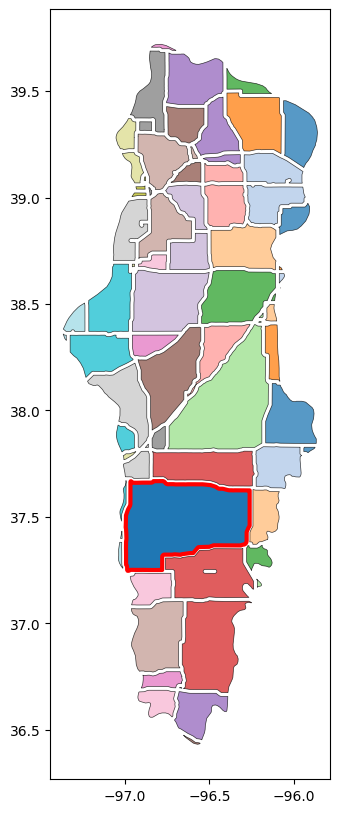

In [252]:
# Plot fragmented areas
fig, ax = plt.subplots(figsize=(10, 10))
gdf_patches.plot(ax=ax, alpha=0.75, linewidth=0.5, cmap='tab20', edgecolor='black')
gdf_patches.loc[[idx_largest_area],'geometry'].plot(ax=ax, edgecolor='red', linewidth=3)

plt.show()

## Load cropland datalayer

This layer will help us understand which polygons are dominated by cropland and which polygons are still dominated by grassland vegetation

In [254]:
# Land use
cdl = ee.ImageCollection('USDA/NASS/CDL')
cdl_layer = cdl.filter(ee.Filter.date('2020-01-01', '2021-12-31')).first().clip(region)
cropland = cdl_layer.select('cropland')

# Single-band GeoTIFF files wrapped in a zip file.
url = cropland.getDownloadUrl({
    'region': region.geometry(),
    'scale':100,
    'format': 'GEO_TIFF'
})


# Request data using URL and save data as a new GeoTiff file
response = requests.get(url)
with open('../datasets/spatial/cropland.tif', 'wb') as f:
    f.write(response.content)

In [255]:
# Read GeoTiff file using the Xarray package
raster = xr.open_dataarray('../datasets/spatial/cropland.tif').squeeze()
raster = raster.rio.reproject(wgs84)

In [258]:
# Examine raster file
raster

<xarray.DataArray 'band_data' (y: 3560, x: 1658)>
array([[ nan,  nan,  nan, ...,  37.,  37., 176.],
       [ nan,  nan,  nan, ..., 111., 111.,   5.],
       [ nan,  nan,  nan, ...,  37.,  37.,   5.],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)
Coordinates:
  * x            (x) float64 -97.39 -97.39 -97.39 ... -95.86 -95.86 -95.86
  * y            (y) float64 39.72 39.72 39.72 39.72 ... 36.43 36.43 36.43 36.43
    band         int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

## Define custom colormap

In [279]:
# Define your labels and their corresponding colors
info = cropland.getInfo()

class_names = info['properties']['cropland_class_names']
class_values = info['properties']['cropland_class_values']
class_colors = info['properties']['cropland_class_palette']
class_colors = ['#'+c for c in class_colors]


In [280]:
# Create the colormap
cmap = ListedColormap(class_colors)

# Create a norm with boundaries
norm = BoundaryNorm(class_values, cmap.N)

## Clip and save cropland map for each polygon

In this step we are clipping the cropland datalayer for each polygon and then saving that clipped and masked image into the GeoDataframe.


In [281]:
# Check that the CRS are the same before clipping the layer
gdf_patches.crs == raster.rio.crs

True

In [282]:
# Define a function to clip the raster with each polygon and return a numpy array
def clip_raster(polygon, raster):
    
    # Clip the raster with the polygon
    clipped = raster.rio.clip([polygon.geometry], crs=raster.rio.crs, all_touched=True)
    
    return clipped


# Apply the function to each row in the GeoDataFrame to create a new 'clipped_raster' column
gdf_patches['clipped_raster'] = gdf_patches.apply(lambda row: clip_raster(row, raster), axis=1)

# Inspect resulting GeoDataframe
gdf_patches.head(3)


,BIOME_NAME,BIOME_NUM,COLOR,COLOR_BIO,COLOR_NNH,ECO_BIOME_,ECO_ID,ECO_NAME,LICENSE,NNH,NNH_NAME,OBJECTID,REALM,SHAPE_AREA,SHAPE_LENG,geometry,area,clipped_raster
0,"Temperate Grasslands, Savannas & Shrublands",8,#A87001,#FEFF73,#EE1E23,NE08,392,Flint Hills tallgrass prairie,CC-BY 4.0,4,Nature Imperiled,271,Nearctic,2.873636,9.461116,"POLYGON ((-95.99115 39.43608, -95.91121 39.396...",4.267920e+08,[[<xarray.DataArray 'band_data' ()>\narray(143...
1,"Temperate Grasslands, Savannas & Shrublands",8,#A87001,#FEFF73,#EE1E23,NE08,392,Flint Hills tallgrass prairie,CC-BY 4.0,4,Nature Imperiled,271,Nearctic,2.873636,9.461116,"POLYGON ((-96.06161 38.08792, -96.05381 38.080...",5.749008e+08,[[<xarray.DataArray 'band_data' ()>\narray(nan...
2,"Temperate Grasslands, Savannas & Shrublands",8,#A87001,#FEFF73,#EE1E23,NE08,392,Flint Hills tallgrass prairie,CC-BY 4.0,4,Nature Imperiled,271,Nearctic,2.873636,9.461116,"POLYGON ((-95.87537 37.82449, -95.88215 37.819...",1.079830e+07,[[<xarray.DataArray 'band_data' ()>\narray(nan...


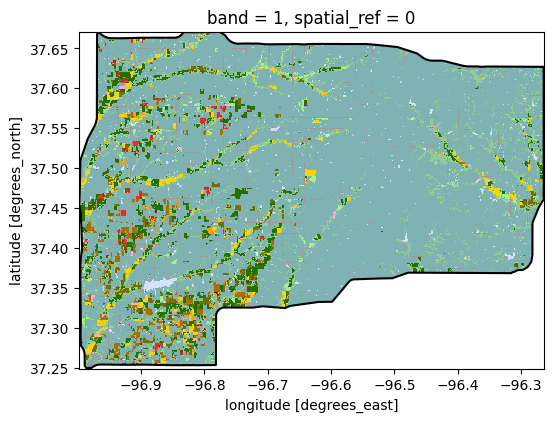

In [303]:
# Create figure showing the cropland data layer for a selected polygon
fig, ax = plt.subplots(figsize=(6, 6))

gdf_patches.loc[[idx_largest_area],'geometry'].boundary.plot(ax=ax, edgecolor='k')
gdf_patches.loc[idx_largest_area,'clipped_raster'].plot(ax=ax, cmap=cmap, 
                                                        norm=norm, add_colorbar=False)
plt.show()


## Clip all fragmentated areas to cropland data layer

This process involves rasterizing each polygon to match the spatial resolution of the cropland data layer.

In [299]:
# Define the transformation and shape from the raster metadata
transform = raster.rio.transform()
shape = (raster.rio.height, raster.rio.width)

# Rasterize the polygons
rasterized_image = rasterize(
    [(geometry, 1) for geometry in gdf_patches.geometry],
    out_shape=shape,
    fill=0,  # Background value for raster cells not covered by polygons
    transform=transform,
    all_touched=True  # Set to True if you want to include all pixels touched by geometries
)

# Convert the rasterized image to an xarray DataArray
rasterized_da = xr.DataArray(rasterized_image, dims=("y", "x"), coords=raster.coords)

# Overlay the rasterized polygons on the raster by using the where method
# This will mask the raster outside the polygons
masked_raster = raster.where(rasterized_da == 1)


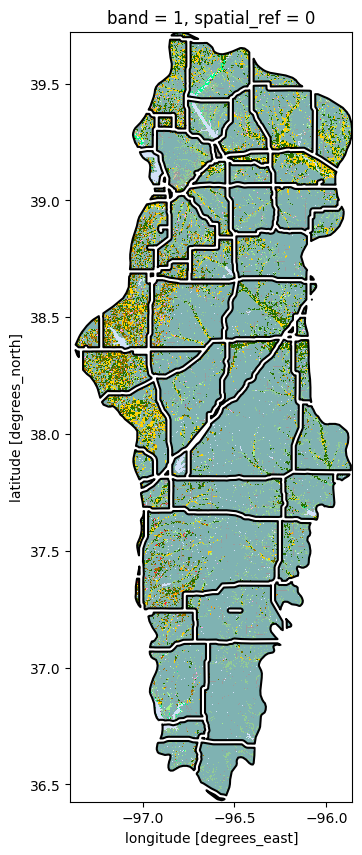

In [301]:
# Create figure showing the cropland data layer for all polygons
fig, ax = plt.subplots(figsize=(10, 10))
masked_raster.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
gdf_patches.boundary.plot(ax=ax, edgecolor='k')
plt.show()